# Midterm

Name: Pratik Naik <br>
Course: Introduction to Deep Learning (CS672) <br>
CRN: 23203 <br>
Term: Spring 2025

# Building a Convolutional Neural Network (CNN) to classify images in the Food-101 dataset into one of the 101 food categories.

## Install the TensorFlow Metal plugin to enable GPU acceleration on Apple Silicon (M1)

Install the TensorFlow Metal plugin to enable GPU acceleration on Apple Silicon (M1 Pro)
This plugin allows TensorFlow to leverage the GPU on Apple Silicon devices, significantly speeding up training times.

In [ ]:
# pip install tensorflow-metal

## Importing Libraries

In [ ]:
#conda install -c conda-forge tensorflow-datasets # Installing Tensorflow Datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

## Load the Food-101 dataset

In [4]:
# Loading the Dataset using tfds
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

2025-03-18 16:54:37.209774: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-18 16:54:37.209831: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-18 16:54:37.209844: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-18 16:54:37.209874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 16:54:37.209902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TFDS is trying to download the Food101 dataset but is sometimes facing issues due to missing Google authentication credentials and network resolution errors.

### If Loading via TFDS does not work, Try manually loading the Dataset from directory

In [27]:
#data_dir = "/Users/pratiknaik/tensorflow_datasets/food-101/food-101/images" 

## Image Preprocessing

In [6]:
# Preprocess images by resizing and normalizing
IMG_SIZE = 128

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 32x32
    image = image / 255.0  # Normalize the image to [0, 1]
    return image, label

In [8]:
train_ds = train_ds.map(preprocess_image) # Apply the preprocess_image function to each element in the dataset
train_ds = train_ds.batch(16) # Batch the dataset into groups of 16 samples
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) # Prefetch data to improve training efficiency by loading the next batch while the current batch is being processed

# Apply the same preprocessing steps to the test dataset
test_ds = test_ds.map(preprocess_image)  
test_ds = test_ds.batch(16)  
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)  


## Displaying Sample Images

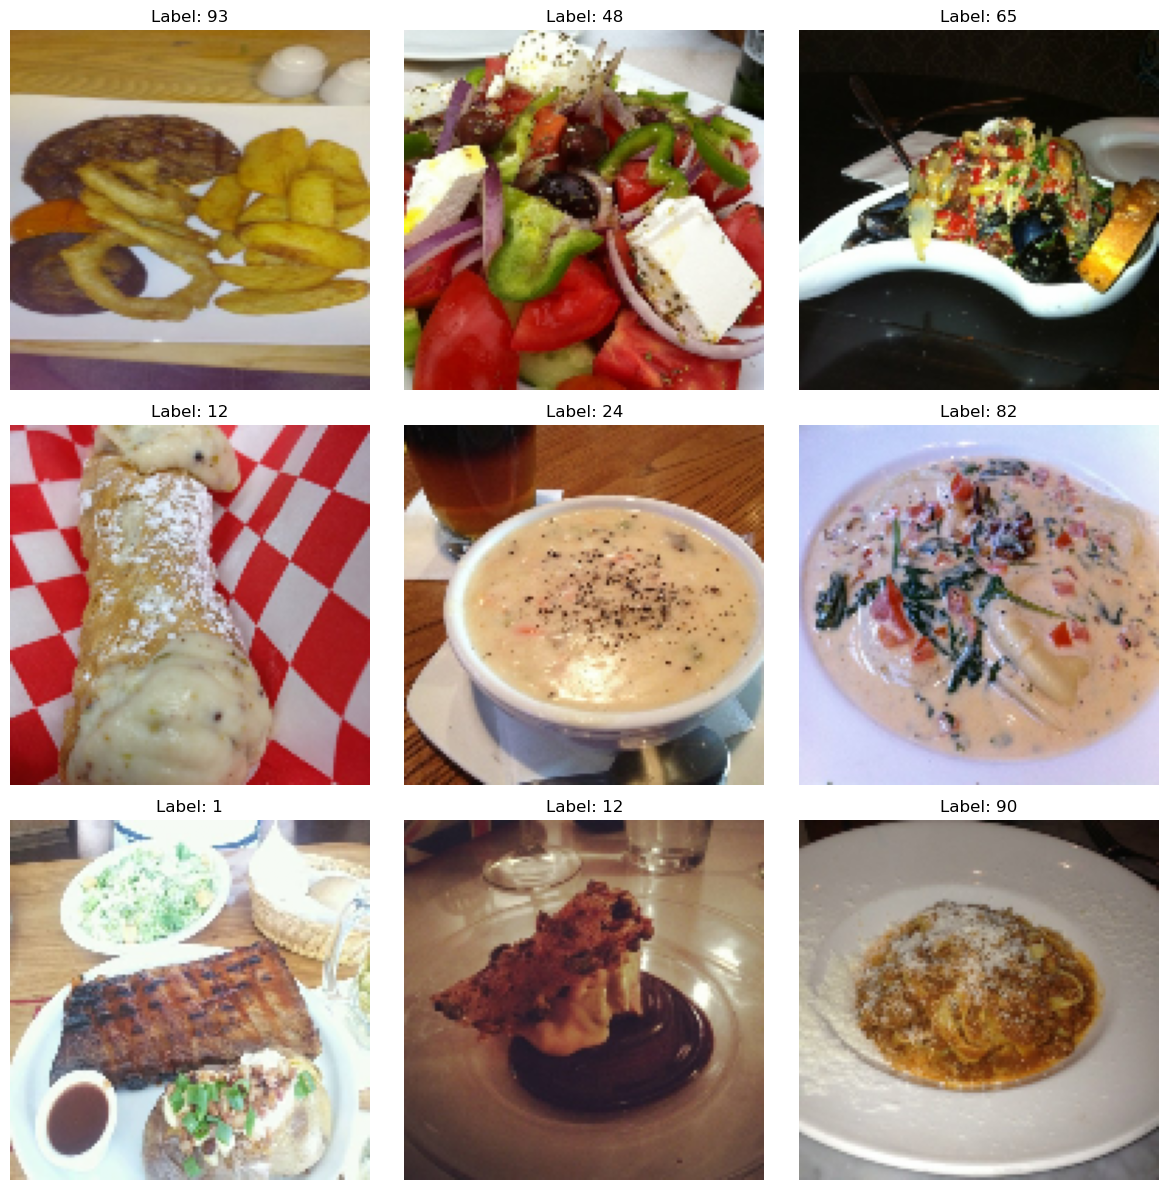

In [12]:
def show_sample_images(dataset, num_samples=9):
    # Get one batch of images and labels from the dataset
    images, labels = next(iter(dataset))  # Get the first batch from the dataset

    # Plot the first `num_samples` images in a 3x3 grid
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        ax = plt.subplot(3, 3, i + 1)  # Set a 3x3 grid
        ax.imshow(images[i].numpy())  # Convert tensor to numpy and plot the image
        ax.set_title(f'Label: {labels[i].numpy()}')  # Show the label (food category)
        ax.axis('off')  # Hide axis labels
    plt.tight_layout()
    plt.show()

# Show 9 sample images from the training dataset
show_sample_images(train_ds, num_samples=9)


## Data Augmentation

In [16]:
# Define a data augmentation pipeline with random flipping, rotation, zoom, and contrast adjustments  
data_augmentation = tf.keras.Sequential([layers.RandomFlip('horizontal'), layers.RandomRotation(0.2), layers.RandomZoom(0.2), layers.RandomContrast(0.2)])


## CNN Model

In [28]:
#As my system was facing an AttributeError in module 'optree' I needed to reinstall it
#conda install optree

Retrieving notices: done
Channels:
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
doneing environment: \ 

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - optree


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.2.25  |       hca03da5_0         131 KB
    optree-0.14.1              |  py311h48ca7d4_0         415 KB
    ------------------------------------------------------------
                                           Total:         546 KB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2025.1.3~ --> pkgs/main::ca-certificates-2025.2.25-hca03da5_0 
  optree             conda-forge::optree-0.9.0-py311hd6ee2~ --> pkgs/main::optree-0.14.1-py311h48ca7d4_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            

In [30]:
# Define data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Define the CNN architecture
model = models.Sequential([
    layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,  # Apply data augmentation

    # Convolutional layers with max pooling
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output for fully connected layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Regularization to avoid overfitting
    layers.Dense(101, activation='softmax')  # Output layer for 101 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,781 (538.21 KB)

 Trainable params: 137,781 (538.21 KB)

 Non-trainable params: 0 (0.00 B)

## Early stopping callback

In [32]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

## Training the Model

In [40]:
# Train the model
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=test_ds,
    callbacks=[early_stopping]
)

Epoch 1/15
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 184s 39ms/step - accuracy: 0.0094 - loss: 4.6159 - val_accuracy: 0.0099 - val_loss: 4.6152
Epoch 2/15
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 185s 39ms/step - accuracy: 0.0091 - loss: 4.6159 - val_accuracy: 0.0099 - val_loss: 4.6153
Epoch 3/15
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 186s 39ms/step - accuracy: 0.0089 - loss: 4.6160 - val_accuracy: 0.0099 - val_loss: 4.6153
Epoch 4/15
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 185s 39ms/step - accuracy: 0.0092 - loss: 4.6160 - val_accuracy: 0.0099 - val_loss: 4.6153


## Evaluate Model's Accuracy

In [38]:
# Evaluate model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.0103 - loss: 4.6151
Test Accuracy: 0.0099
Test Loss: 4.6152


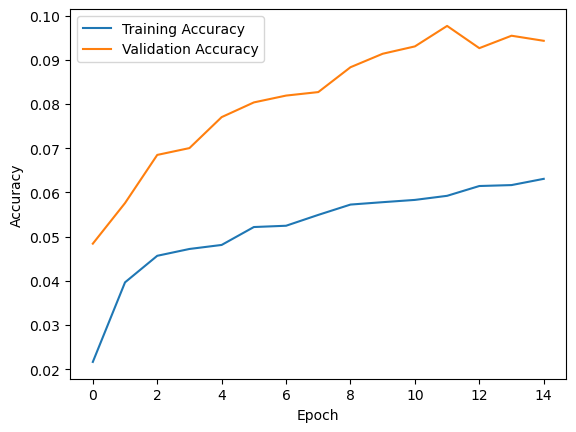

In [50]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()